In [37]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import matplotlib.pyplot as plt
import numpy as np
import pickle


import keras
from keras.layers import InputLayer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))
#print(sys.path)
import util.items as items

In [38]:
item = 'Abyssal_whip'

In [39]:
items.getPrices(item)[-10:]

[2663958,
 2643140,
 2626840,
 2614224,
 2606262,
 2593007,
 2593049,
 2587581,
 2581066,
 2581709]

In [40]:
items.getInfo(item)

{'members': 'True',
 'edible': 'False',
 'update': '/w/Update:Slayer_Skill',
 'quest': 'No',
 'destroy': 'Drop',
 'image': '/w/File:Abyssal_whip.png',
 'lowAlch': '48000',
 'examine': 'A weapon from the abyss.',
 'highAlch': '72000',
 'storeprice': 'N/A',
 'seller': 'N/A',
 'equipable': 'True',
 'weight': '0.453',
 'released': '26 January 2005',
 'storeCurrency': 'N/A',
 'name': 'Abyssal_whip',
 'alchable': 'True',
 'exchangePrice': '2622266',
 'tradeable': 'True',
 'buyLimit': '70',
 'noteable': 'True',
 'stackable': 'False'}

1286 1295 1286


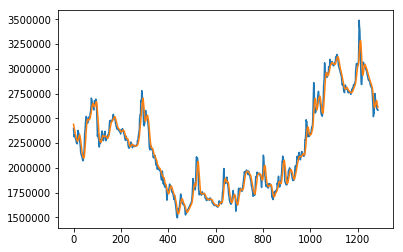

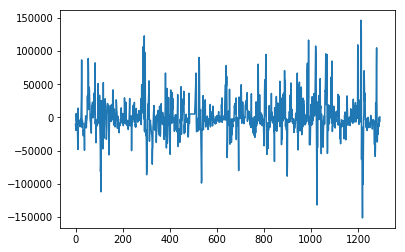

In [41]:
ma = 10
prices = items.getPrices(item)
changes = items.getPriceChanges(item)
movAvg = items.movingAverage(item,ma)
print(len(movAvg),len(prices),len(prices[ma-1:]))
plt.plot(prices[ma-1:])
plt.plot(movAvg)
plt.plot()
plt.show()
plt.plot(changes)
plt.show()

[-0.39886178 -0.59478149 -0.73148709  0.21354183 -0.21807331]


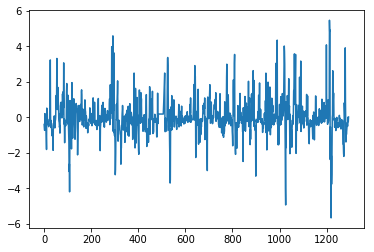

1286 1286


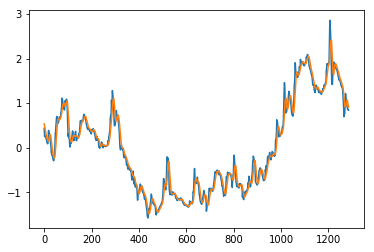

In [54]:
scaler = StandardScaler()
s_changes = scaler.fit_transform(np.array(changes).reshape(-1, 1)).reshape(len(changes),)
s_movAvg = scaler.fit_transform(np.array(movAvg).reshape(-1, 1)).reshape(len(movAvg),)
s_prices = scaler.fit_transform(np.array(prices).reshape(-1, 1)).reshape(len(prices),)
print(s_changes[0:5])
plt.plot(s_changes)
plt.show()
print(len(s_prices[-len(s_movAvg):]),len(s_movAvg))
plt.plot(s_prices[-len(s_movAvg):])
plt.plot(s_movAvg)
plt.show()

In [43]:
x = []
y = []
p = []
f_sizes = [5]
size = sum(f_sizes)
for i in range(len(prices)-size-1):
    x.append(s_changes[i:i+size])
    y.append(changes[i+size])
print(x[1],y[0])
print(len(x[0]),len(x[-1]))
print(len(x),len(y),len(p))

[-0.59478149 -0.73148709  0.21354183 -0.21807331 -0.23773644] -6272
5 5
1289 1289 0


In [57]:
x = []
y = []
p = []
size = 5
for i in range(-1*len(s_movAvg),-1*size,1):
    x.append(s_changes[i:i+size]+s_movAvg[i:i+size])
    y.append(changes[i+size])
    p.append(prices[i+size])
print(x[1],y[0])
print(len(x[0]),len(x[-1]))
print(len(x),len(y),len(p))

[-0.80218521 -1.33911781  0.96503072  0.20750705  0.20017816] -4952
5 5
1281 1281 1281


In [62]:
s1 = int(len(y)*.8)
s2  =int(len(y)*.9)
x_train = np.array(x[:s1])
y_train = np.array(y[:s1])
x_val = np.array(x[s1:s2])
y_val = np.array(y[s1:s2])
x_test = np.array(x[s2:])
y_test = np.array(y[s2:])
p_test = np.array(p[s2:])
print(len(x_train),len(y_train),len(x_val),len(y_val),len(x_test),len(y_test),len(p_test))
print(len(x_train[0]),x_train[0])
print(y_train[0])
print(len(x_test[0]),x_test[0])
print(y_test[0])

1024 1024 128 128 129 129 129
5 [-0.02928783 -0.80218521 -1.33911781  0.96503072  0.20750705]
-4952.0
5 [1.00164983 1.26493391 1.32456939 1.1677674  1.37593906]
-4633.0


129 129


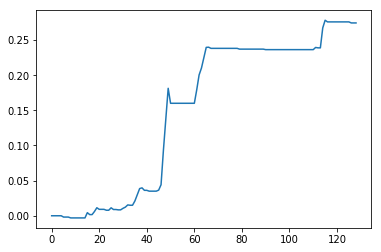

In [63]:
import util.trading_systems as ts

data = prices[-1*len(y_test):]
chan = s_changes[-1*len(y_test)-1:-1]
budget = 100 * data[-1]
bl = int(items.getInfo(item)['buyLimit'])
print(len(data),len(chan))
pp = ts.perfectProfit(chan,0,y_test,data,bl,budget)
plt.plot(pp)
plt.show()

In [73]:
model = Sequential()
model.add(Dense(10, input_dim=size, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_20 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
sgd = SGD(lr=0.2)
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(x_train, y_train,
            validation_data=(x_val,y_val),
            epochs=50,
            batch_size=10)

Train on 1024 samples, validate on 128 samples
Epoch 1/50
1024/1024 [==============================] - 1s 574us/step - loss: 636522541.8516 - mean_squared_error: 636522541.8516 - val_loss: 645599641.7500 - val_mean_squared_error: 645599641.7500
Epoch 2/50
1024/1024 [==============================] - 0s 111us/step - loss: 636517744.1016 - mean_squared_error: 636517744.1016 - val_loss: 645597175.7500 - val_mean_squared_error: 645597175.7500
Epoch 3/50
1024/1024 [==============================] - 0s 126us/step - loss: 636511243.9766 - mean_squared_error: 636511243.9766 - val_loss: 645593348.3750 - val_mean_squared_error: 645593348.3750
Epoch 4/50
1024/1024 [==============================] - 0s 114us/step - loss: 636500688.6250 - mean_squared_error: 636500688.6250 - val_loss: 645587528.0000 - val_mean_squared_error: 645587528.0000
Epoch 5/50
1024/1024 [==============================] - 0s 109us/step - loss: 636482440.8906 - mean_squared_error: 636482440.8906 - val_loss: 645577107.2500 - va

Epoch 42/50
1024/1024 [==============================] - 0s 98us/step - loss: 609609213.6641 - mean_squared_error: 609609213.6641 - val_loss: 628247222.7500 - val_mean_squared_error: 628247222.7500
Epoch 43/50
1024/1024 [==============================] - 0s 124us/step - loss: 608270335.2188 - mean_squared_error: 608270335.2188 - val_loss: 627631978.1250 - val_mean_squared_error: 627631978.1250
Epoch 44/50
1024/1024 [==============================] - 0s 142us/step - loss: 606878936.8281 - mean_squared_error: 606878936.8281 - val_loss: 626999450.6250 - val_mean_squared_error: 626999450.6250
Epoch 45/50
1024/1024 [==============================] - 0s 110us/step - loss: 605526196.8047 - mean_squared_error: 605526196.8047 - val_loss: 626385928.0000 - val_mean_squared_error: 626385928.0000
Epoch 46/50
1024/1024 [==============================] - 0s 106us/step - loss: 604104770.2461 - mean_squared_error: 604104770.2461 - val_loss: 625820032.3750 - val_mean_squared_error: 625820032.3750
Epoch 

In [75]:
score = model.evaluate(x_test, y_test, batch_size=1)
print(score)

129/129 [==============================] - 0s 485us/step
[1317157532.099594, 1317157532.099594]


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


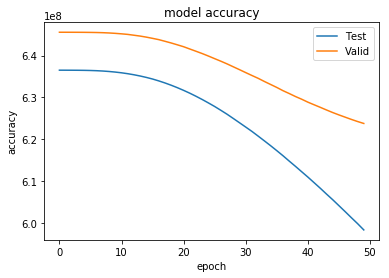

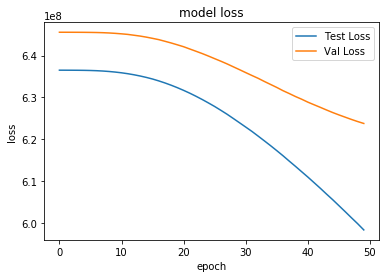

In [76]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'],label='Test')
plt.plot(history.history['val_mean_squared_error'],label='Valid')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label='Test Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

[[4465.451 ]
 [4040.4565]
 [3275.592 ]
 [3246.311 ]
 [3673.7043]]


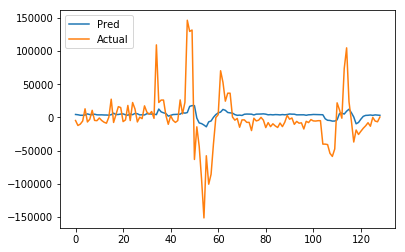

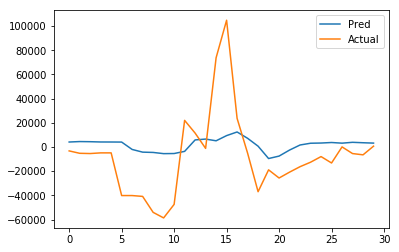

In [69]:
y_pred = model.predict(x_test)
print(y_pred[:5])
plt.plot(y_pred,label='Pred')
plt.plot(y_test,label='Actual')
plt.legend()
plt.show()
plt.plot(y_pred[-30:],label='Pred')
plt.plot(y_test[-30:],label='Actual')
plt.legend()
plt.show()

In [50]:
bl = int(items.getInfo(item)['buyLimit'])
print(len(x_test))
budgets = [10**5,10**6,10**7,10**8,10**9]
mpBest = [([-100],-1)] * len(budgets)
ppBest = [([-100],-1)] * len(budgets)
bhBest = [([-100],-1)] * len(budgets)
perBest = [([-100],-1)] * len(budgets)
for b in range(len(budgets)):
    print(budgets[b])
    t = 0
    bhBest[b] = ts.buyAndHold(p_test,bl,budgets[b])
    for i in range(10):
        mp = ts.modelProfit(x_test,t,model,p_test,bl,budgets[b])
        if mp[-1]>mpBest[b][0][-1] and mp[-1]!=0.0:
            mpBest[b] = (mp,t)
        pp = ts.perfectProfit(x_test,t,y_test,p_test,bl,budgets[b])
        if pp[-1]>ppBest[b][0][-1]:
            ppBest[b] = (pp,t)
        per = ts.persistanceProfit(x_test,t,y_test,p_test,bl,budgets[b])
        if per[-1]>perBest[b][0][-1]:
            perBest[b] = (per,t)
        t += .02

194
100000


IndexError: index 0 is out of bounds for axis 0 with size 0

In [184]:
for b in range(len(budgets)):
    print(budgets[b])
    print('\tModel\n\t',mpBest[b][0][-1],mpBest[b][1])
    print('\tPerfect\n\t',ppBest[b][0][-1],ppBest[b][1])
    print('\tBuy and Hold\n\t',bhBest[b][-1])

100000
	Model
	 0.146885 0.18
	Perfect
	 1.17309 0.02
	Buy and Hold
	 0.29355
1000000
	Model
	 0.146937 0.18
	Perfect
	 1.174284 0.02
	Buy and Hold
	 0.293778
10000000
	Model
	 0.1961788 0.06
	Perfect
	 0.4853202 0
	Buy and Hold
	 0.0684
100000000
	Model
	 0.02598 0
	Perfect
	 0.0504 0
	Buy and Hold
	 0.00684
1000000000
	Model
	 0.002598 0
	Perfect
	 0.00504 0
	Buy and Hold
	 0.000684


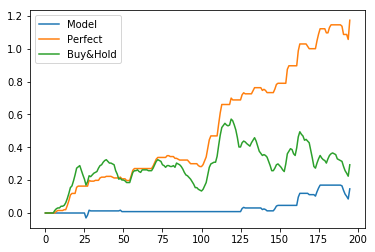

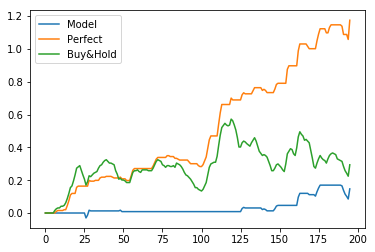

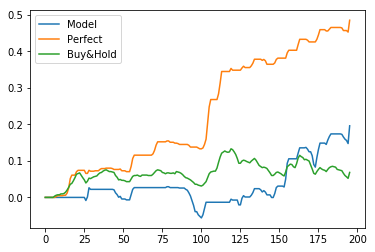

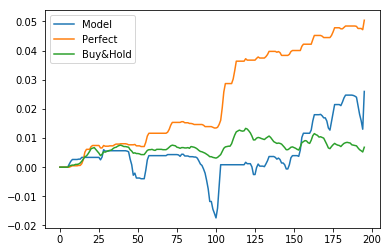

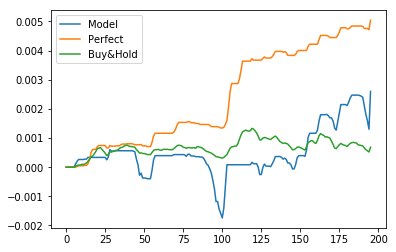

In [185]:
for b in range(len(budgets)):
    plt.plot(mpBest[b][0],label='Model')
    plt.plot(ppBest[b][0],label='Perfect')
    plt.plot(bhBest[b],label='Buy&Hold')
    plt.legend()
    plt.show()